# Derive waterbody relative topography using Landsat

This notebook demonstrates how to load Landsat time series data, compute a water index, generate a rolling median water index composites, extract contours along the land-water boundary, and finally interpolate between contours to produce a 3D relative topographic surface. This relative topography could be easily calibrated to obtain absolute bathymetry (and accordingly, volume estimates) with a simple GPS transect from the highest to the deepest part of the lake during a dry period.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [51]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
import sys
import glob
import gdal
import affine
import fiona
import collections
import rasterio
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely import geometry
from shapely.geometry import MultiLineString, mapping
from rasterstats import zonal_stats
from skimage import measure
from skimage import filters
from skimage import exposure

from datacube.utils import geometry
from datacube.utils.geometry import CRS


dc = datacube.Datacube()


def contour_extract(z_values, ds_array, ds_crs, ds_affine, output_shp=None, min_vertices=2,
                    attribute_data=None, attribute_dtypes=None):

    """
    Uses `skimage.measure.find_contours` to extract contour lines from a two-dimensional array.
    Contours are extracted as a dictionary of xy point arrays for each contour z-value, and optionally as
    line shapefile with one feature per contour z-value.
    The `attribute_data` and `attribute_dtypes` parameters can be used to pass custom attributes to the output
    shapefile.
    Last modified: September 2018
    Author: Robbi Bishop-Taylor
    :param z_values:
        A list of numeric contour values to extract from the array.
    :param ds_array:
        A two-dimensional array from which contours are extracted. This can be a numpy array or xarray DataArray.
        If an xarray DataArray is used, ensure that the array has one two dimensions (e.g. remove the time dimension
        using either `.isel(time=0)` or `.squeeze('time')`).
    :param ds_crs:
        Either a EPSG string giving the coordinate system of the array (e.g. 'EPSG:3577'), or a crs
        object (e.g. from an xarray dataset: `xarray_ds.geobox.crs`).
    :param ds_affine:
        Either an affine object from a rasterio or xarray object (e.g. `xarray_ds.geobox.affine`), or a gdal-derived
        geotransform object (e.g. `gdal_ds.GetGeoTransform()`) which will be converted to an affine.
    :param min_vertices:
        An optional integer giving the minimum number of vertices required for a contour to be extracted. The default
        (and minimum) value is 2, which is the smallest number required to produce a contour line (i.e. a start and
        end point). Higher values remove smaller contours, potentially removing noise from the output dataset.
    :param output_shp:
        An optional string giving a path and filename for the output shapefile. Defaults to None, which
        does not generate a shapefile.
    :param attribute_data:
        An optional dictionary of lists used to define attributes/fields to add to the shapefile. Dict keys give
        the name of the shapefile attribute field, while dict values must be lists of the same length as `z_values`.
        For example, if `z_values=[0, 10, 20]`, then `attribute_data={'type: [1, 2, 3]}` can be used to create a
        shapefile field called 'type' with a value for each contour in the shapefile. The default is None, which
        produces a default shapefile field called 'z_value' with values taken directly from the `z_values` parameter
        and formatted as a 'float:9.2'.
    :param attribute_dtypes:
        An optional dictionary giving the output dtype for each shapefile attribute field that is specified by
        `attribute_data`. For example, `attribute_dtypes={'type: 'int'}` can be used to set the 'type' field to an
        integer dtype. The dictionary should have the same keys/field names as declared in `attribute_data`.
        Valid values include 'int', 'str', 'datetime, and 'float:X.Y', where X is the minimum number of characters
        before the decimal place, and Y is the number of characters after the decimal place.
    :return:
        A dictionary with contour z-values as the dict key, and a list of xy point arrays as dict values.
    :example:
    >>> # Import modules
    >>> import sys
    >>> import datacube
    >>> # Import external dea-notebooks functions using relative link to Scripts directory
    >>> sys.path.append('../10_Scripts')
    >>> import SpatialTools
    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Contour extraction')
    >>> # Define an elevation query
    >>> elevation_query = {'lat': (-35.25, -35.35),
    ...                    'lon': (149.05, 149.17),
    ...                    'output_crs': 'EPSG:3577',
    ...                    'resolution': (-25, 25)}
    >>> # Import sample elevation data
    >>> elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
    >>> # Remove the time dimension so that array is two-dimensional
    >>> elevation_2d = elevation_data.dem_h.squeeze('time')
    >>> # Extract contours
    >>> contour_dict = SpatialTools.contour_extract(z_values=[600, 700, 800],
    ...                                             ds_array=elevation_2d,
    ...                                             ds_crs=elevation_2d.geobox.crs,
    ...                                             ds_affine=elevation_2d.geobox.affine,
    ...                                             output_shp='extracted_contours.shp')
    Extracting contour 600
    Extracting contour 700
    Extracting contour 800
    <BLANKLINE>
    Exporting contour shapefile to extracted_contours.shp
    """

    # First test that input array has only two dimensions:
    if len(ds_array.shape) == 2:

        # Obtain affine object from either rasterio/xarray affine or a gdal geotransform:
        if type(ds_affine) != affine.Affine:

            ds_affine = affine.Affine.from_gdal(*ds_affine)

        ####################
        # Extract contours #
        ####################

        # Output dict to hold contours for each offset
        contours_dict = collections.OrderedDict()

        for z_value in z_values:

            # Extract contours and convert output array pixel coordinates into arrays of real world Albers coordinates.
            # We need to add (0.5 x the pixel size) to x values and subtract (-0.5 * pixel size) from y values to
            # correct coordinates to give the centre point of pixels, rather than the top-left corner
            print(f'Extracting contour {z_value}')
            ps = ds_affine[0]  # Compute pixel size
            contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                            find_contours(ds_array, z_value)]

            # For each array of coordinates, drop any xy points that have NA
            contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]

            # Drop 0 length and add list of contour arrays to dict
            contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]

            # If there is data for the contour, add to dict:
            if len(contours_withdata) > 0:
                contours_dict[z_value] = contours_withdata
            else:
                print(f'    No data for contour {z_value}; skipping')

        #######################
        # Export to shapefile #
        #######################

        # If a shapefile path is given, generate shapefile
        if output_shp:

            print(f'\nExporting contour shapefile to {output_shp}')

            # If attribute fields are left empty, default to including a single z-value field based on `z_values`
            if not attribute_data:

                # Default field uses two decimal points by default
                attribute_data = {'z_value': z_values}
                attribute_dtypes = {'z_value': 'float:9.2'}

            # Set up output multiline shapefile properties
            schema = {'geometry': 'MultiLineString',
                      'properties': attribute_dtypes}

            # Create output shapefile for writing
            with fiona.open(output_shp, 'w',
                            crs={'init': str(ds_crs), 'no_defs': True},
                            driver='ESRI Shapefile',
                            schema=schema) as output:

                # Write each shapefile to the dataset one by one
                for i, (z_value, contours) in enumerate(contours_dict.items()):

                    # Create multi-string object from all contour coordinates
                    contour_multilinestring = MultiLineString(contours)

                    # Get attribute values for writing
                    attribute_vals = {field_name: field_vals[i] for field_name, field_vals in attribute_data.items()}

                    # Write output shapefile to file with z-value field
                    output.write({'properties': attribute_vals,
                                  'geometry': mapping(contour_multilinestring)})

        # Return dict of contour arrays
        return contours_dict

    else:
        print(f'The input `ds_array` has shape {ds_array.shape}. Please input a two-dimensional array (if your '
              f'input array has a time dimension, remove it using `.isel(time=0)` or `.squeeze(\'time\')`)')

        
# Extract vertex coordinates and heights from geopandas
def contours_to_arrays(gdf, col):
    
    coords_zvals = []
    
    for i in range(1, len(gdf)):
        
        val = gdf.iloc[i][col]
    
        try:
            coords = np.concatenate([np.vstack(x.coords.xy).T for x in gdf.iloc[i].geometry])
            
        except:
            coords = np.vstack(gdf.iloc[i].geometry.coords.xy).T

        coords_zvals.append(np.column_stack((coords, np.full(np.shape(coords)[0], fill_value=val))))
    
    return np.concatenate(coords_zvals)


def interpolate_timeseries(ds, freq='7D', method='linear'):
    
    """
    Interpolate new data between each existing xarray timestep at a given
    frequency. For example, `freq='7D'` will interpolate new values at weekly
    intervals from the start time of the xarray dataset to the end time. 
    `freq='24H'` will interpolate new values for each day, etc.
    
    :param ds:
        The xarray dataset to interpolate new time-step observations for.
        
    :param freq:
        An optional string giving the frequency at which to interpolate new time-step 
        observations. Defaults to '7D' which interpolates new values at weekly intervals; 
        for a full list of options refer to Panda's list of offset aliases: 
        https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
        
    :param method:
        An optional string giving the interpolation method to use to generate new time-steps.
        Default is 'linear'; options are {'linear', 'nearest'} for multidimensional arrays and
        {'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'} for 1-dimensional arrays.
        
    :return:
        A matching xarray dataset covering the same time period as `ds`, but with an 
        interpolated for each time-step given by `freq`.
        
    """    
    
    # Use pandas to generate dates from start to end of ds at a given frequency
    start_time = ds.isel(time=0).time.values.item() 
    end_time = ds.isel(time=-1).time.values.item()    
    from_to = pd.date_range(start=start_time, end=end_time, freq=freq)
    
    # Use these dates to linearly interpolate new data for each new date
    print('Interpolating {} time-steps at {} intervals'.format(len(from_to), freq))
    return ds.interp(coords={'time': from_to}, method=method)

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, SpatialTools


In [122]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
import sys
import glob
import gdal
import affine
import fiona
import collections
import rasterio
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely import geometry
from shapely.geometry import MultiLineString, mapping
from rasterstats import zonal_stats
from skimage import measure
from skimage import filters
from skimage import exposure

from datacube.utils import geometry
from datacube.utils.geometry import CRS


dc = datacube.Datacube()


def interpolate_timeseries(ds, freq='7D', method='linear'):
    
    """
    Interpolate new data between each existing xarray timestep at a given
    frequency. For example, `freq='7D'` will interpolate new values at weekly
    intervals from the start time of the xarray dataset to the end time. 
    `freq='24H'` will interpolate new values for each day, etc.
    
    :param ds:
        The xarray dataset to interpolate new time-step observations for.
        
    :param freq:
        An optional string giving the frequency at which to interpolate new time-step 
        observations. Defaults to '7D' which interpolates new values at weekly intervals; 
        for a full list of options refer to Panda's list of offset aliases: 
        https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
        
    :param method:
        An optional string giving the interpolation method to use to generate new time-steps.
        Default is 'linear'; options are {'linear', 'nearest'} for multidimensional arrays and
        {'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'} for 1-dimensional arrays.
        
    :return:
        A matching xarray dataset covering the same time period as `ds`, but with an 
        interpolated for each time-step given by `freq`.
        
    """    
    
    # Use pandas to generate dates from start to end of ds at a given frequency
    start_time = ds.isel(time=0).time.values.item() 
    end_time = ds.isel(time=-1).time.values.item()    
    from_to = pd.date_range(start=start_time, end=end_time, freq=freq)
    
    # Use these dates to linearly interpolate new data for each new date
    print('Interpolating {} time-steps at {} intervals'.format(len(from_to), freq))
    return ds.interp(coords={'time': from_to}, method=method)

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, SpatialTools


In [156]:
# Contour extraction and interpolation parameters
min_vertices = 2  # This can be used to remove noise by dropping contours with less than X vertices
guassian_sigma = 0  # Controls amount of smoothing to apply to interpolated raster. Higher = smoother


In [336]:
name='thilmere'
latitude_extents = (-34.2117,  -34.2372)
longitude_extents = (150.5333, 150.5496)
time_extents = ('1988-01-01', '2019-03-01')

name='thilmere_1'
latitude_extents = (-34.2188,  -34.2288)
longitude_extents = (150.5388, 150.546)
time_extents = ('1988-01-01', '2019-03-01')

# name='test2'
# latitude_extents = (-30.1633720285, -30.127021544)
# longitude_extents = (147.306395967, 147.422629533)
# time_extents = ('2013-01-01', '2018-11-01')

query = dict(latitude=latitude_extents, longitude=longitude_extents, time=time_extents)

DEAPlotting.display_map(x=longitude_extents, y=latitude_extents, crs='EPSG:4326')

## Import Landsat data and mask by cloud

Loading ls5
    Loading 619 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 127 filtered ls7 timesteps
Loading ls8
    Loading 259 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


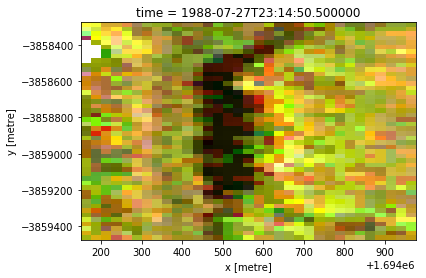

In [337]:
# Set up parameters for cloud/pixel quality masking
mask_dict = dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)

landsat_dataset = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'],
                                                   bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],  
                                                   mask_dict = mask_dict, 
                                                   masked_prop=0.0, 
                                                   mask_pixel_quality=True,
                                                   mask_invalid_data=True,
                                                   ls7_slc_off=False)

# Plot single time step
landsat_dataset[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True)


### Compute water index for each timestep

In [338]:
# Calculate MNDWI water index (gives best results in turbid inland waters)
landsat_dataset['mndwi'] = ((landsat_dataset.green - landsat_dataset.swir1) / 
                            (landsat_dataset.green + landsat_dataset.swir1))
    
# landsat_dataset['ndwi'] = (landsat_dataset.green - landsat_dataset.nir) / \
#                            (landsat_dataset.green + landsat_dataset.nir)
    
# landsat_dataset['awei'] = (4 * (landsat_dataset.green * 0.0001 - landsat_dataset.swir1 * 0.0001) -
#                            (0.25 * landsat_dataset.nir * 0.0001 + 2.75 * landsat_dataset.swir2 * 0.0001))


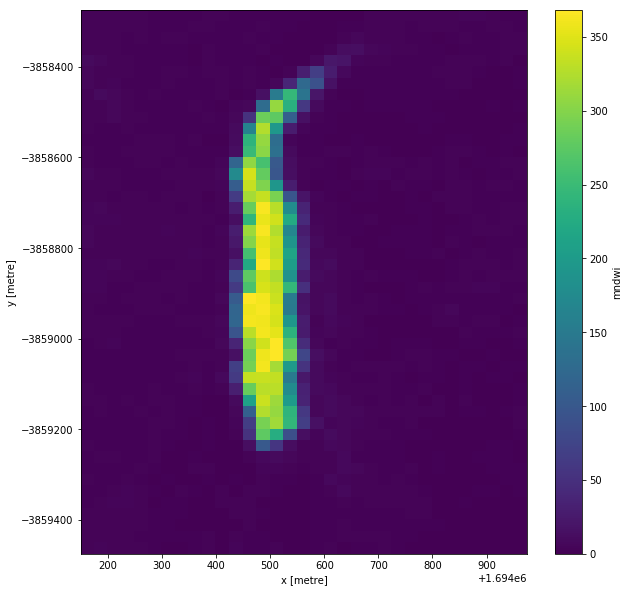

In [339]:
(landsat_dataset.mndwi > 0).sum(dim='time').plot(figsize=(10,10))

## Compute percentages of valid data and inundation per timestep

In [340]:
# Create mask of max extent of water (land = 0, water = 1) and create new layer with
# NaN for all pixels outside max extent area
max_water_mask = ~((landsat_dataset.mndwi.fillna(-1) < 0).min(dim='time'))
mndwi_water_masked = landsat_dataset.mndwi.where(max_water_mask)

# Calculate the valid data percentage for each time step by dividing the number of 
# non-NaN pixels in timestep by the total number of pixels in the max extent water layer
landsat_dataset['data_perc'] = (mndwi_water_masked.count(dim=['x', 'y']) / 
                               (max_water_mask).sum())

# Calculate innundation percent
inundation_perc = ((mndwi_water_masked > 0).sum(dim=['x', 'y']) /  
                    mndwi_water_masked.count(dim=['x', 'y']))
landsat_dataset['inundation_perc'] = inundation_perc

# Sort in reverse order by inundation percentage (from wet to dry)
landsat_dataset = landsat_dataset.sortby('inundation_perc', ascending=False)

# Restrict to scenes with greater than 20% valid data and select variables for further analysis
to_keep = (landsat_dataset.data_perc > 0.2) & (landsat_dataset.inundation_perc < 0.9)
cleaned_subset = landsat_dataset[['mndwi', 'data_perc', 'inundation_perc']].sel(time = to_keep)


### Export time series

Interpolating 378 time-steps at 30D intervals


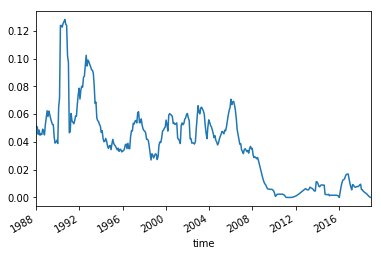

In [383]:
# Plot only observations with greater than 20% valid data
timeseries_subset = landsat_dataset.sel(time = to_keep).inundation_perc

# # Interpolate to one point per week, then take a rolling mean to smooth line for plotting
timeseries_subset = interpolate_timeseries(timeseries_subset.sortby('time'), freq='30D', method='linear')
timeseries_subset = timeseries_subset.rolling(time=10, min_periods=1, center=True).mean()

# Export to text file
timeseries_subset_df = timeseries_subset.to_dataframe(name='innundation_perc')
timeseries_subset_df['date'] = timeseries_subset_df.index.floor('d')
timeseries_subset_df.set_index('date')
# timeseries_subset_df = timeseries_subset_df.loc[timeseries_subset_df.innundation_perc < 0.1]
timeseries_subset_df.to_csv('relative_topography/{}_timeseries.csv'.format(name))
timeseries_subset_df.innundation_perc.plot()

## Compute median NDWI composites using a rolling 20 observation median

In [342]:
timesteps = len(cleaned_subset.time)
print('{} timesteps in total'.format(timesteps))

# Create output list to hold NDWI median composites
out = []

for i in np.arange(0, timesteps, 1):
    
    # identify min and max index to extract rolling median
    min_index = max(i - 20, 0)
    max_index = min(i + 20, timesteps)
#     print('Creating median NDWI composite using indices {} to {}'.format(min_index, max_index))
    
    # Take median of dates that match indexes and add to list
    median_dataset = cleaned_subset.isel(time=slice(min_index, max_index)).median(dim='time')
    out.append(median_dataset)
out

# Combine each median composite into a single xarray dataset
combined = xr.concat(out, dim='inundation_perc').sortby('inundation_perc')


682 timesteps in total


## Extract contours from each median composite observation

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to relative_topography/thilmere_1_combined.shp


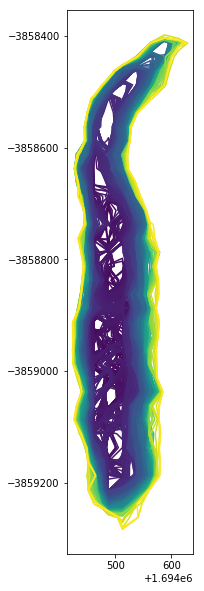

In [349]:
# Prepare attributes as input to contour extract
attribute_data = {'in_perc': (combined.inundation_perc  * 100).values.tolist()}
attribute_dtypes = {'in_perc': 'float'}

# Set threshold
thresh = 0

# Extract contours with custom attribute fields:
gdf = SpatialTools.contour_extract(z_values=[thresh],
                               ds_array=combined.mndwi,
                               ds_crs='epsg:3577',
                               ds_affine=landsat_dataset.geobox.transform,
                               output_shp=f'relative_topography/{name}_combined.shp',
                               min_vertices=10,  
                               attribute_data=attribute_data,
                               attribute_dtypes=attribute_dtypes,
                               verbose=False,
                               dim='inundation_perc')

# Plot contours
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='in_perc', cmap='viridis')

## Interpolate

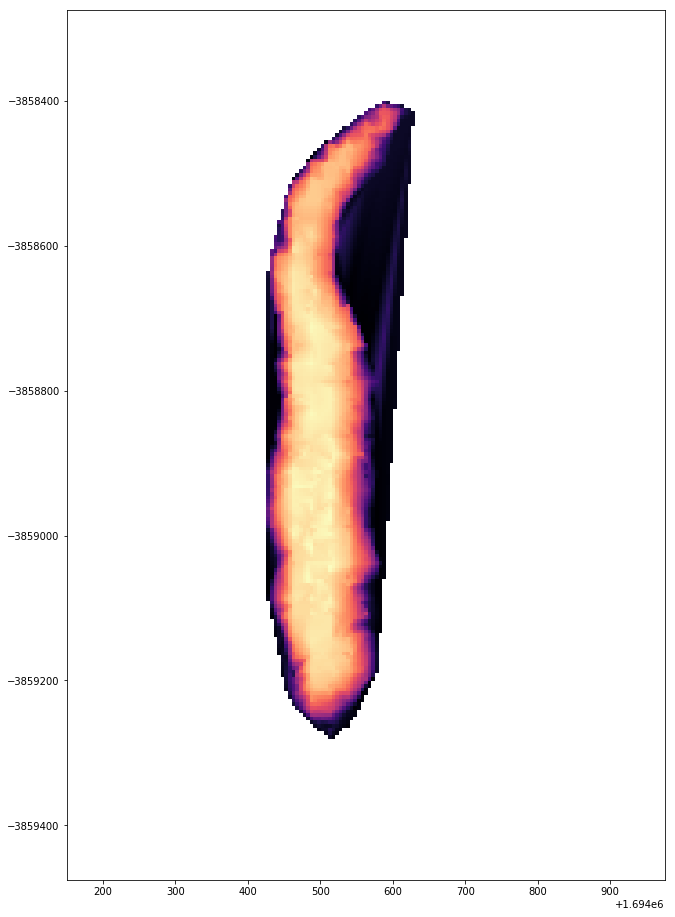

In [350]:
# Extract vertex coordinates and heights from geopandas
def contours_to_arrays(gdf, col):

    coords_zvals = []

    for i in range(1, len(gdf)):

        val = gdf.iloc[i][col]

        try:
            coords = np.concatenate([np.vstack(x.coords.xy).T for x in gdf.iloc[i].geometry])

        except:
            coords = np.vstack(gdf.iloc[i].geometry.coords.xy).T

        coords_zvals.append(np.column_stack((coords, np.full(np.shape(coords)[0], fill_value=val))))

    return np.concatenate(coords_zvals)

# Extract x, y and z points for interpolation
all_contours = contours_to_arrays(gdf=gdf, col='in_perc')
points_xy = all_contours[:, [1, 0]]
values_elev = all_contours[:, 2]

# Create grid to interpolate into
x_size, _, upleft_x, _, y_size, upleft_y =  landsat_dataset.geobox.transform[0:6]
yrows, xcols = landsat_dataset.red.shape[1:]

# Optionally reduce resolution
x_size /= 5
y_size /= 5
yrows *= 5
xcols *= 5

bottomright_x = upleft_x + (x_size * xcols)
bottomright_y = upleft_y + (y_size * yrows)

grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

# Interpolate x, y and z values using linear/TIN interpolation
out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

# Set areas outside of NDWI composites to highest innundation percentage
# test = (combined.mndwi > 0).max(dim='inundation_perc')
# out[~test] = np.nanmax(out)
# out[np.isnan(out)] = np.nanmax(out)

# Apply guassian blur to smooth transitions between z values (optional)
# out = filters.gaussian(out, sigma=guassian_sigma)
# out = exposure.rescale_intensity(out, out_range=(timeseries_subset.min().item() - 0.001, 
#                                                  timeseries_subset.max().item() + 0.001))

# Plot interpolated surface
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(out, cmap='magma_r', extent=[upleft_x, bottomright_x, bottomright_y, upleft_y])
# gdf.plot(ax=ax, edgecolor='white', linewidth=0.5, alpha=0.5)

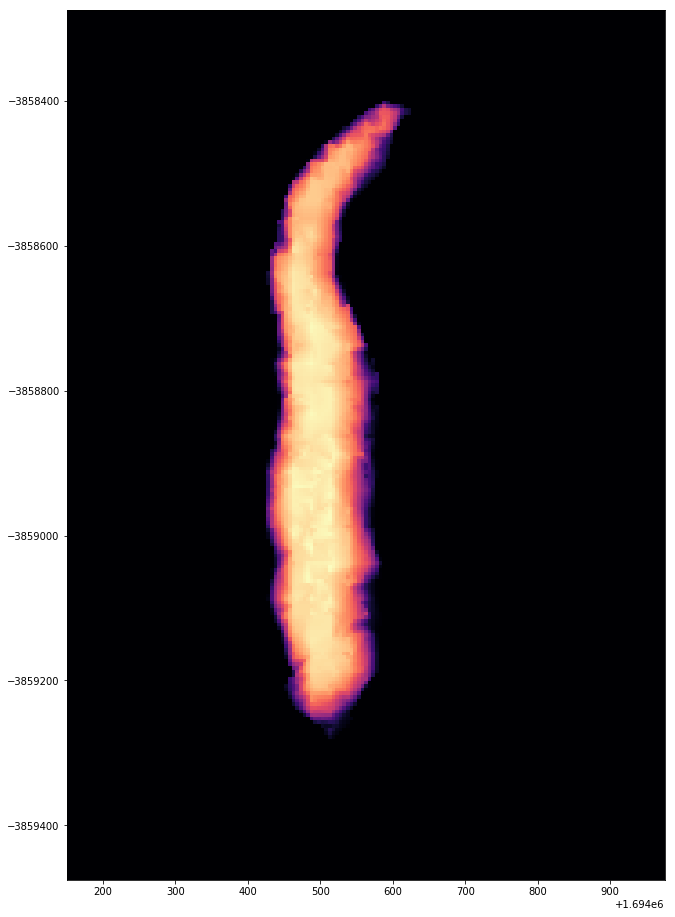

In [367]:
import geopandas as gpd
from rasterio import features
from shapely.geometry import Polygon, MultiPolygon

# dem_transform = landsat_dataset.geobox.transform

# Reduced resolution transform
dem_transform = list(landsat_dataset.geobox.transform)[0:6]
dem_transform[0] = dem_transform[0] / 5
dem_transform[4] = dem_transform[4] / 5
dem_transform

# Identify all geometry objects in shapefile
# shapes = [(Polygon(shape), n) for n, shape in enumerate(gdf.iloc[-1].geometry)]
shapes = [(Polygon(gdf.iloc[-1].geometry), 1)]

# Generate mask
xarray_mask = features.rasterize(shapes, out_shape=(yrows, xcols),
                                 fill=0, transform=dem_transform,
                                 all_touched=True, dtype=np.int16)

out[~xarray_mask.astype(bool)] = np.nanmax(out)
out[~np.isfinite(out)] = np.nanmax(out)

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(out, cmap='magma_r', extent=[upleft_x, bottomright_x, bottomright_y, upleft_y])


## Export DEM and RGB arrays to file

In [368]:
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:3577',
         'transform': dem_transform,
         'nodata': -9999}

with rasterio.open('relative_topography/{}_dem.tif'.format(name), 'w', **kwargs) as target:
    target.write_band(1, out)

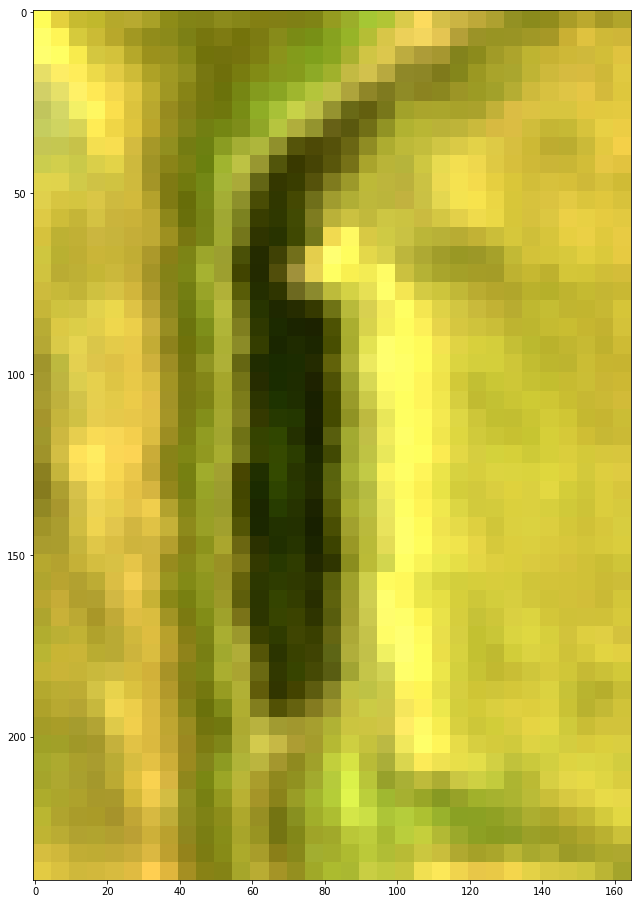

In [366]:
# Select a single cloud free image  with low inundation
data_array = landsat_dataset.sel(time = (landsat_dataset.data_perc > 0.8) & 
             (landsat_dataset.inundation_perc < 0.2)).mean(dim='time')[['red', 'green', 'blue']].to_array().values

# Optimise colours using a percentile stretch
rgb_array = np.transpose(data_array, [1, 2, 0])
rgb_array = scipy.misc.imresize(rgb_array, size=25 / 5.0, interp='nearest').astype(np.float)
p_low, p_high = np.nanpercentile(rgb_array, [2, 98])
img_toshow = exposure.rescale_intensity(rgb_array, in_range=(p_low, p_high), out_range=(0, 1))
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(img_toshow)

# Change dtype to int16 scaled between 0 and 10000 to save disk space
img_toshow = (img_toshow * 10000).astype(rasterio.int16)

kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 3,
         'dtype': rasterio.int16,
         'crs': 'EPSG:3577',
         'transform': dem_transform,
         'nodata': -9999}

with rasterio.open('relative_topography/{}_rgb.tif'.format(name), 'w', **kwargs) as target:
    target.write(np.transpose(img_toshow, [2, 0, 1]))

In [195]:
def resample_array(a, factor=2):

    import numpy
    import scipy
    from scipy import ndimage, signal


    # Empty image enlarged by scale factor
    b = numpy.zeros((a.shape[0]*factor, a.shape[1]*factor))

    # Fill the new array with the original values
    b[::factor,::factor] = a

    # Define the convolution kernel
    kernel_1d = scipy.signal.boxcar(factor)
    kernel_2d = numpy.outer(kernel_1d, kernel_1d)

    # Apply the kernel by convolution, seperately in each axis
    c = scipy.signal.convolve(b, kernel_2d, mode="valid")
    
    return c
    
resample_r = resample_array(rgb_array[:,:,0], factor=5)
resample_g = resample_array(rgb_array[:,:,1], factor=5)
resample_b = resample_array(rgb_array[:,:,2], factor=5)
rgb_array = np.stack([resample_r, resample_r, resample_r], axis=2) 
